In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/Floodnet'

/content/drive/MyDrive/Floodnet


In [3]:
ls

floodnet_model_dice.h5  test.rar


In [4]:
!unrar x test.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from test.rar

Creating    test                                                      OK
Extracting  test/10170_2048_512.jpg                                        0%  OK 
Extracting  test/10170_2048_512_lab.png                                    0%  OK 
Extracting  test/10170_512_512.jpg                                         0%  OK 
Extracting  test/10170_512_512_lab.png                                     0%  OK 
Extracting  test/10171_1024_2048.jpg                                       0%  OK 
Extracting  test/10171_1024_2048_lab.png                                   0%  OK 
Extracting  test/10171_512_1536.jpg                                        0%  OK 
Extracting  test/10171_512_1536_lab.png                                    0%  OK 
Extracting  test/10172_1024_0.jpg                                          0%  O

In [9]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to load and preprocess images and masks
def preprocess_images_and_masks(folder_path):
    images = []
    masks = []

    # Get list of filenames from directory
    file_names = os.listdir(folder_path)

    for filename in file_names:
        if filename.endswith('.jpg'):  # Assuming images are .jpg
            # Load image
            image_path = os.path.join(folder_path, filename)
            mask_path = os.path.join(folder_path, filename.replace('.jpg', '_lab.png'))  # Adjust mask filename

            if os.path.exists(mask_path):  # Ensure mask exists for the image
                image = load_img(image_path)   # Load and resize image
                mask = load_img(mask_path, color_mode='grayscale')  # Load and resize mask

                # Convert images and masks to numpy arrays and normalize
                image_array = img_to_array(image) / 255.0
                mask_array = img_to_array(mask)

                images.append(image_array)
                masks.append(mask_array)

    return np.array(images), np.array(masks)


In [10]:
test_dir = 'test'

In [11]:
test_images, test_masks = preprocess_images_and_masks(test_dir)
np.save('test_images.npy', test_images)
np.save('test_masks.npy', test_masks)


print(f"Training images shape: {test_images.shape}, dtype: {test_images.dtype}")
print(f"Training masks shape: {test_masks.shape}, dtype: {test_masks.dtype}")

Training images shape: (869, 512, 512, 3), dtype: float32
Training masks shape: (869, 512, 512, 1), dtype: float32


Loaded training images shape: (869, 512, 512, 3), dtype: float32
Loaded training masks shape: (869, 512, 512, 1), dtype: float32


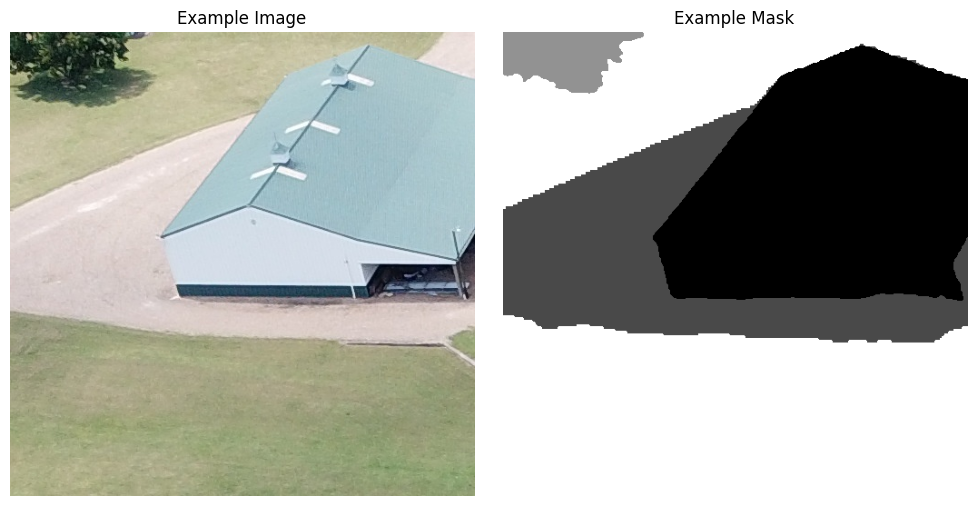

In [12]:
import numpy as np
import matplotlib.pyplot as plt

train_images_path = 'test_images.npy'
train_masks_path = 'test_masks.npy'

# Load numpy arrays
train_images = np.load(train_images_path)
train_masks = np.load(train_masks_path)

# Print shapes and types to verify
print(f"Loaded training images shape: {train_images.shape}, dtype: {train_images.dtype}")
print(f"Loaded training masks shape: {train_masks.shape}, dtype: {train_masks.dtype}")

# Choose an example index to visualize
example_index = 200

# Display example image and mask
plt.figure(figsize=(10, 5))

# Plot the image
plt.subplot(1, 2, 1)
plt.imshow(train_images[example_index])
plt.title('Example Image')
plt.axis('off')

# Plot the mask
plt.subplot(1, 2, 2)
plt.imshow(train_masks[example_index].squeeze(), cmap='gray')
plt.title('Example Mask')
plt.axis('off')

plt.tight_layout()
plt.show()


In [13]:
test_images = train_images
test_masks = train_masks

In [14]:
test_masks = test_masks.astype(np.uint8)

In [15]:
import tensorflow as tf

In [16]:
test_masks_categorical = tf.keras.utils.to_categorical(test_masks, num_classes=10)

In [17]:
test_masks_categorical.shape

(869, 512, 512, 10)

In [18]:
test_images = train_images *255

In [19]:
test_images = test_images.astype(np.uint8)

In [27]:
import tensorflow as tf
import keras.backend as K

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    num_classes = 10
    dice = 0
    for i in range(num_classes):
        dice += dice_coefficient(y_true[:, :, :, i], y_pred[:, :, :, i])
    return 1 - dice / num_classes


In [29]:
from keras.models import load_model

# Load the model with the custom loss function
model = load_model('floodnet_model_dice.h5', custom_objects={'dice_loss': dice_loss,'dice_coefficient':dice_coefficient})

In [30]:
# Predict on the test images
predictions = model.predict(test_images)

# Convert predictions to the class with the highest probability
predicted_classes = np.argmax(predictions, axis=-1)


28/28 [==============================] - 179s 6s/step


In [31]:
from sklearn.metrics import jaccard_score

# Initialize a dictionary to store IoU for each class
iou_per_class = {}

# Loop through each class from 1 to 9
for class_id in range(1, 10):
    # Create binary masks for the true and predicted labels of the current class
    true_mask = (test_masks == class_id).astype(np.uint8)
    predicted_mask = (predicted_classes == class_id).astype(np.uint8)

    # Flatten the masks
    true_mask_flat = true_mask.flatten()
    predicted_mask_flat = predicted_mask.flatten()

    # Calculate IoU using jaccard_score with the 'binary' option
    iou = jaccard_score(true_mask_flat, predicted_mask_flat, average='binary')

    # Store the IoU for the current class
    iou_per_class[class_id] = iou

# Print the IoU for each class
for class_id, iou in iou_per_class.items():
    print(f"Class {class_id}: IoU = {iou:.4f}")


Class 1: IoU = 0.5947
Class 2: IoU = 0.5150
Class 3: IoU = 0.4600
Class 4: IoU = 0.4117
Class 5: IoU = 0.1371
Class 6: IoU = 0.7518
Class 7: IoU = 0.4809
Class 8: IoU = 0.2479
Class 9: IoU = 0.3161
